In [1]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint # type: ignore #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model # type: ignore #tải mô hình
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore

#các lớp để xây dựng mô hình
from keras.models import Sequential # type: ignore #đầu vào
from keras.layers import LSTM # type: ignore #học phụ thuộc
from keras.layers import Dropout # type: ignore #tránh học tủ
from keras.layers import Dense # type: ignore #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score  # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error  # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error, f1_score  # Đo % sai số tuyệt đối trung bình

from pymongo import MongoClient

In [22]:

# Kết nối đến MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['metadata']  
collection = db['SSB']  

# Chuyển dữ liệu thành DataFrame
df = pd.DataFrame(list(collection.find({}, {"_id": 0})))
df


,Ngay,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
0,2021-04-06,13.82,28.00,1881700,52233000000,0,0,28.00,28.00,27.30,-0.10,-0.36
1,2021-04-12,13.67,27.70,846900,23099000000,0,0,27.30,27.70,27.00,0.00,0.00
2,2021-04-13,13.48,27.30,433600,11819000000,0,0,27.10,27.50,27.10,-0.40,-1.44
3,2021-04-20,13.58,27.50,1465400,40323000000,0,0,27.60,27.60,27.40,0.00,0.00
4,2021-04-22,13.58,27.50,729000,19830000000,0,0,27.30,27.50,26.80,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
934,2024-12-17,17.30,17.30,2372600,40659000000,1342300,23309460000,17.25,17.30,16.95,0.00,0.00
935,2024-12-13,17.35,17.35,1793700,30906000000,0,0,17.25,17.40,17.10,-0.05,-0.29
936,2024-12-18,17.25,17.25,1526600,26256000000,233100,4079250000,17.10,17.25,17.10,-0.05,-0.29
937,2024-12-19,16.50,16.50,2264900,38223000000,4442300,76965250000,17.05,17.10,16.50,-0.75,-4.35


In [23]:
# Kiểm tra dữ liệu
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 939 entries, 0 to 938
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ngay               939 non-null    object 
 1   GiaDieuChinh       939 non-null    float64
 2   GiaDongCua         939 non-null    float64
 3   KhoiLuongKhopLenh  939 non-null    int64  
 4   GiaTriKhopLenh     939 non-null    int64  
 5   KLThoaThuan        939 non-null    int64  
 6   GtThoaThuan        939 non-null    int64  
 7   GiaMoCua           939 non-null    float64
 8   GiaCaoNhat         939 non-null    float64
 9   GiaThapNhat        939 non-null    float64
 10  ThayDoi_GiaTri     939 non-null    float64
 11  ThayDoi_PhanTram   939 non-null    float64
dtypes: float64(7), int64(4), object(1)
memory usage: 88.2+ KB


,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
count,939.000000,939.000000,9.390000e+02,9.390000e+02,9.390000e+02,9.390000e+02,939.000000,939.000000,939.000000,939.000000,939.000000
mean,21.005346,29.440895,1.715096e+06,5.038064e+10,1.893722e+06,4.117487e+10,29.383067,29.644462,28.929553,-0.000032,0.013195
std,2.761197,6.984893,7.872782e+05,2.750399e+10,7.105337e+06,1.281414e+11,6.954151,7.038009,6.736171,0.537310,1.676804
min,9.950000,15.050000,4.336000e+05,1.181900e+10,0.000000e+00,0.000000e+00,15.400000,15.700000,15.050000,-3.450000,-8.410000
25%,19.370000,23.000000,1.121350e+06,3.053750e+10,0.000000e+00,0.000000e+00,22.900000,23.050000,22.650000,-0.150000,-0.460000
50%,21.340000,30.500000,1.633400e+06,4.005400e+10,0.000000e+00,0.000000e+00,30.450000,30.600000,30.100000,0.000000,0.000000
75%,23.060000,35.375000,2.100050e+06,6.624200e+10,3.000000e+00,7.000000e+04,35.300000,35.750000,34.600000,0.100000,0.320000
max,26.760000,45.600000,6.007500e+06,1.860710e+11,1.024108e+08,1.521871e+12,45.750000,45.900000,44.950000,2.700000,6.960000


In [24]:
# Xử lý thời gian và sắp xếp dữ liệu
df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
df = df.sort_values(by='Ngay')

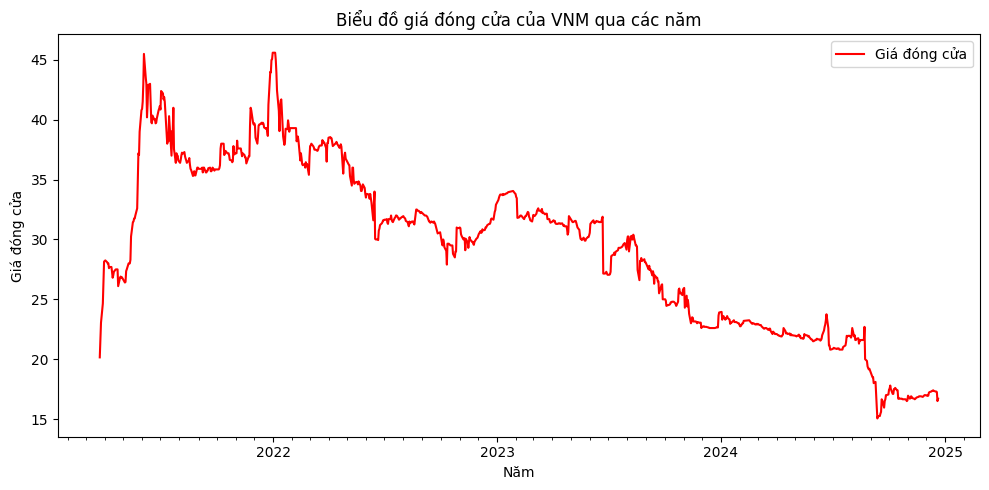

In [25]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Lấy thông tin năm từ cột "Ngày"
df['Nam'] = df['Ngay'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Ngay'], df['GiaDongCua'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của VNM qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [26]:
# Chuyển đổi sang chỉ số thời gian
df1 = pd.DataFrame(df, columns=['Ngay', 'GiaDongCua'])
df1.index = df1['Ngay']
df1.drop('Ngay', axis=1, inplace=True)

In [27]:
df1

,GiaDongCua
Ngay,
2021-03-24,20.15
2021-03-25,21.55
2021-03-26,23.05
2021-03-29,24.65
2021-03-30,26.35
...,...
2024-12-16,17.30
2024-12-17,17.30
2024-12-18,17.25


In [28]:
# Chia tập dữ liệu
data = df1.values
train_data = data[:int(len(df) * 0.8)]
test_data = data[int(len(df) * 0.8):]

In [29]:
data

array([[20.15],
       [21.55],
       [23.05],
       [24.65],
       [26.35],
       [28.15],
       [28.2 ],
       [28.25],
       [28.1 ],
       [28.  ],
       [28.  ],
       [27.6 ],
       [27.7 ],
       [27.7 ],
       [27.3 ],
       [26.8 ],
       [27.  ],
       [27.3 ],
       [27.5 ],
       [27.5 ],
       [27.5 ],
       [26.1 ],
       [26.8 ],
       [26.9 ],
       [26.8 ],
       [26.85],
       [26.4 ],
       [26.45],
       [27.35],
       [27.5 ],
       [28.  ],
       [28.  ],
       [28.  ],
       [28.3 ],
       [30.25],
       [31.45],
       [31.5 ],
       [31.75],
       [31.75],
       [32.  ],
       [32.6 ],
       [34.85],
       [37.2 ],
       [37.05],
       [39.  ],
       [40.8 ],
       [40.9 ],
       [41.5 ],
       [43.  ],
       [45.5 ],
       [43.5 ],
       [43.  ],
       [40.2 ],
       [41.3 ],
       [42.9 ],
       [43.  ],
       [41.3 ],
       [39.8 ],
       [39.7 ],
       [40.35],
       [40.  ],
       [40.05],
       [

In [30]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)

In [31]:
# Tạo cửa sổ thời gian cho tập train
x_train, y_train = [], []
for i in range(50, len(train_data)):
    x_train.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_train.append(sc_train[i, 0])  # Giá trị tiếp theo
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [32]:
# Tạo cửa sổ thời gian cho tập test
x_test, y_test = [], []
for i in range(50, len(test_data)):
    x_test.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_test.append(sc_train[i, 0])  # Giá trị tiếp theo
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

C:\Users\TRUONG\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100

Epoch 1: loss improved from inf to 0.51043, saving model to save_models/simple_LSTM_model.keras
13/13 - 4s - 338ms/step - loss: 0.5104 - val_loss: 0.7544
Epoch 2/100

Epoch 2: loss improved from 0.51043 to 0.45003, saving model to save_models/simple_LSTM_model.keras
13/13 - 1s - 40ms/step - loss: 0.4500 - val_loss: 0.6636
Epoch 3/100

Epoch 3: loss improved from 0.45003 to 0.38046, saving model to save_models/simple_LSTM_model.keras
13/13 - 1s - 41ms/step - loss: 0.3805 - val_loss: 0.5624
Epoch 4/100

Epoch 4: loss improved from 0.38046 to 0.30465, saving model to save_models/simple_LSTM_model.keras
13/13 - 0s - 36ms/step - loss: 0.3047 - val_loss: 0.4349
Epoch 5/100

Epoch 5: loss improved from 0.30465 to 0.20598, saving model to save_models/simple_LSTM_model.keras
13/13 - 1s - 47ms/step - loss: 0.2060 - val_loss: 0.2460
Epoch 6/100

Epoch 6: loss improved from 0.20598 to 0.10178, saving model to save_models/simple_LSTM_model.keras
13/13 - 0s - 36ms/step - loss: 0.1018 - 

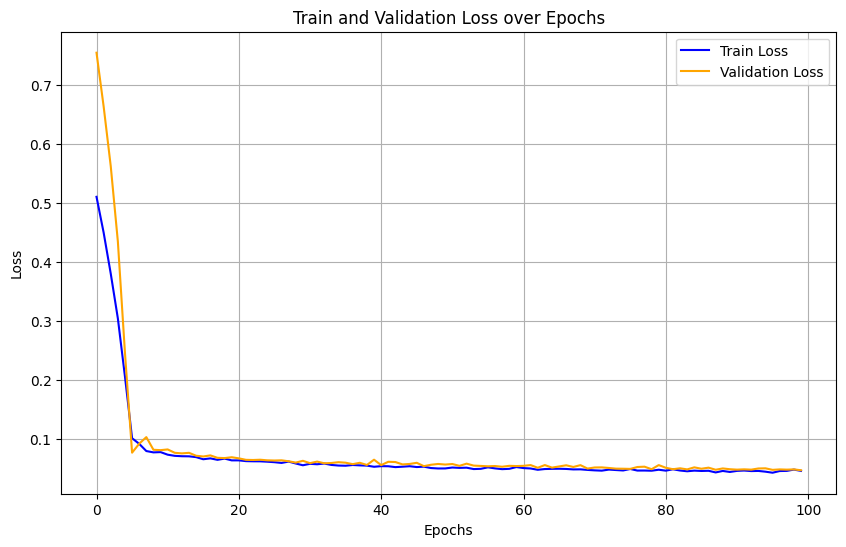

In [13]:
def build_simple_model(input_shape):
    model = Sequential()
    
    # Chỉ 1 lớp LSTM
    model.add(LSTM(units=64, input_shape=input_shape, 
                   kernel_regularizer=l2(0.001)))  # Thêm regularization để giảm overfitting
    
    # Dropout để tăng độ tổng quát
    model.add(Dropout(0.3))
    
    # Lớp Dense để dự đoán đầu ra
    model.add(Dense(1))
    
    # Compile mô hình
    model.compile(
        loss='mean_absolute_error',  # MAE phù hợp với dự báo giá
        optimizer=Adam(learning_rate=0.0001)  # Learning rate thấp giúp tối ưu ổn định
    )
    
    return model

# Xây dựng mô hình
input_shape = (x_train.shape[1], x_train.shape[2])  # Thay thế phù hợp với dữ liệu đầu vào
model = build_simple_model(input_shape)

# Đường dẫn lưu mô hình
save_model_path = "save_models/simple_LSTM_model.keras"

# Callbacks
callbacks = [
    ModelCheckpoint(save_model_path, monitor='loss', verbose=2, save_best_only=True, mode='auto'),
    EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=2)
]

# Huấn luyện mô hình và lưu kết quả vào history
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),  # Thêm tập validation
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=callbacks
)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')  # Thêm val_loss
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Tải mô hình tốt nhất
save_model_path = "models/SSB_model.keras"
final_model = load_model(save_model_path)

In [34]:
# Dự đoán trên tập train
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict)
y_train = sc.inverse_transform(y_train.reshape(-1, 1))

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


In [35]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[int(len(df) * 0.8):] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


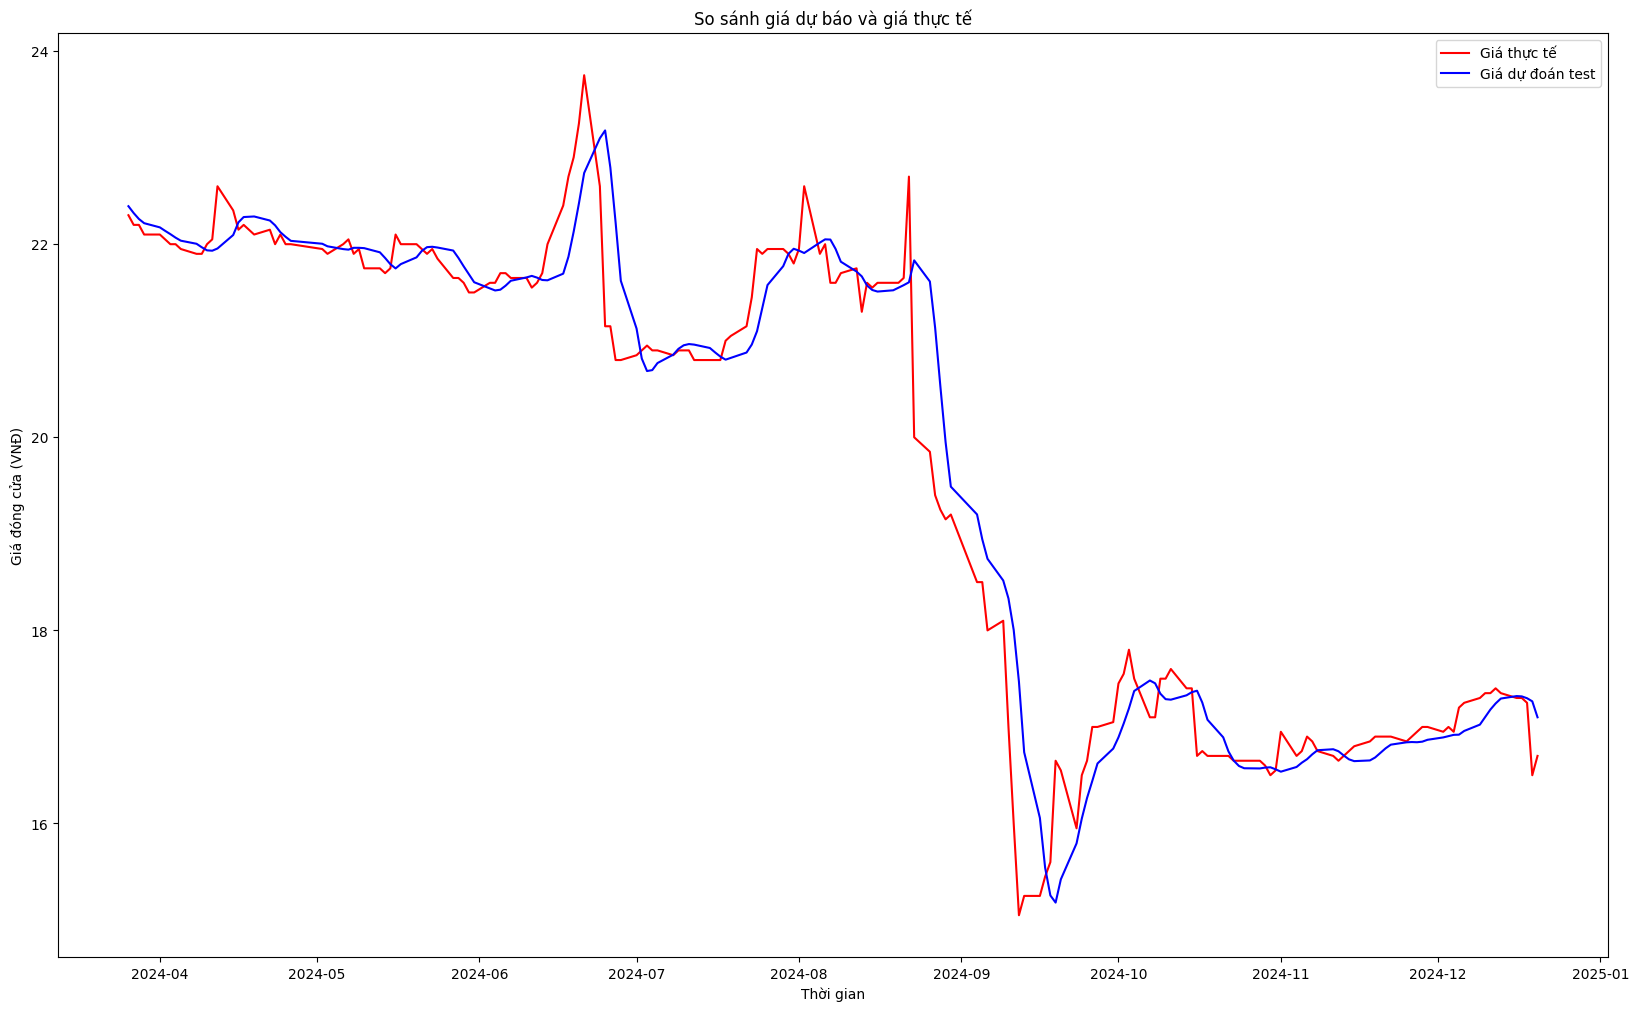

In [37]:
# Chọn dữ liệu cho test_data1
num_test_predictions = len(y_test_predict)
test_data1 = df.iloc[-num_test_predictions:].copy()
plt.figure(figsize=(20, 12))
if 'Ngay' in test_data1.columns:
    plt.plot(test_data1['Ngay'], test_data1['GiaDongCua'], label='Giá thực tế', color='red')
else:
    raise KeyError("Cột 'Ngày' không tồn tại trong test_data1.")

test_data1 = test_data1.copy()
test_data1['Dự đoán'] = y_test_predict.flatten()
plt.plot(test_data1['Ngay'], test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.title('So sánh giá dự báo và giá thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.legend()
plt.show()


In [38]:
print('--- Kết quả trên tập train ---')
# R2 score
print('Độ phù hợp tập train (R2):', r2_score(y_train, y_train_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):', mean_absolute_error(y_train, y_train_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập train:', mean_absolute_percentage_error(y_train, y_train_predict) * 100)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
print('RMSE trên tập train (VNĐ):', rmse_train)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_train = np.max(y_train) - np.min(y_train)
accuracy_train = 1 - (rmse_train / range_y_train)
print('Độ chính xác trên tập train (%):', accuracy_train * 100)

# F1 Score (Chuyển thành bài toán phân loại)
error_threshold = 10  # Ngưỡng sai số
y_train_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
y_train_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
f1_train = f1_score(y_train_class, y_train_pred_class)
print('F1 Score trên tập train:', f1_train)
print("----------------------------------------------------")

--- Kết quả trên tập train ---
Độ phù hợp tập train (R2): 0.9793585995396183
Sai số tuyệt đối trung bình trên tập train (VNĐ): 0.488045747678052
Phần trăm sai số tuyệt đối trung bình trên tập train: 1.4545052968579815
RMSE trên tập train (VNĐ): 0.7777193111262846
Độ chính xác trên tập train (%): 96.69055612286688
F1 Score trên tập train: 1.0
----------------------------------------------------


In [39]:
y_test = data[-len(y_test_predict):]

In [40]:
print('--- Kết quả trên tập test ---')
# R2 score
print('Độ phù hợp tập test (R2):', r2_score(y_test, y_test_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mean_absolute_error(y_test, y_test_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập test:', mean_absolute_percentage_error(y_test, y_test_predict) * 100)

# RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
print('RMSE trên tập test (VNĐ):', rmse_test)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_test = np.max(y_test) - np.min(y_test)
accuracy_test = 1 - (rmse_test / range_y_test)
print('Độ chính xác trên tập test (%):', accuracy_test * 100)

# F1 Score (Chuyển thành bài toán phân loại)
y_test_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
y_test_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
f1_test = f1_score(y_test_class, y_test_pred_class)
print('F1 Score trên tập test:', f1_test)
print("----------------------------------------------------")

--- Kết quả trên tập test ---
Độ phù hợp tập test (R2): 0.9505620431356311
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.31958845219713566
Phần trăm sai số tuyệt đối trung bình trên tập test: 1.6902540746318295
RMSE trên tập test (VNĐ): 0.5406669047391062
Độ chính xác trên tập test (%): 93.785437876562
F1 Score trên tập test: 1.0
----------------------------------------------------


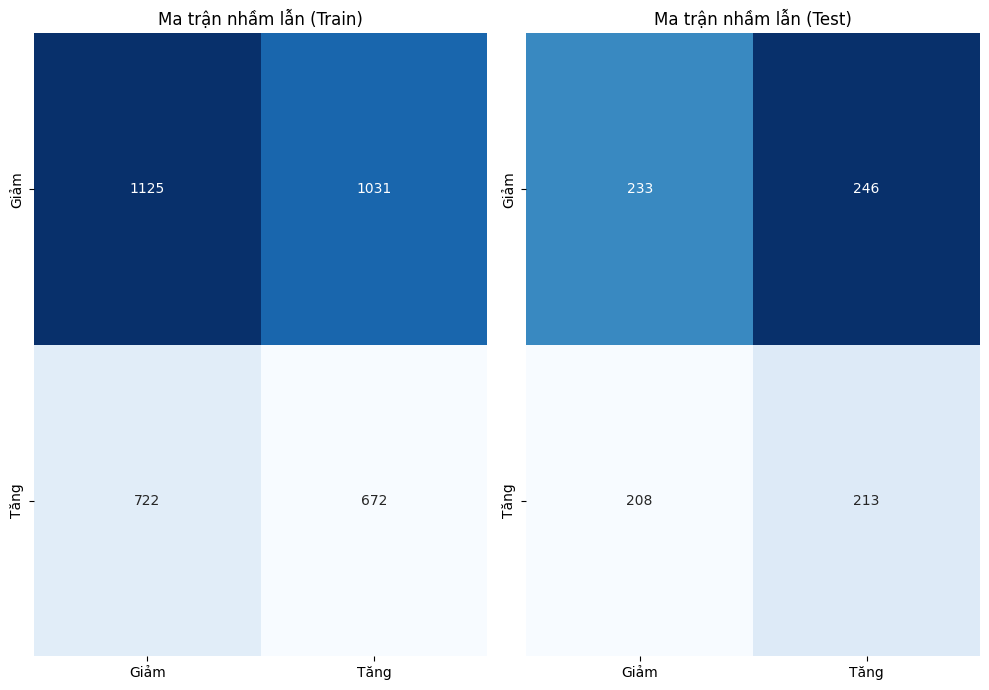

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def create_labels(data):
    return [1 if data[i] > data[i-1] else 0 for i in range(1, len(data))]

# Chuyển đổi giá trị thực tế và dự đoán thành nhãn phân loại
y_train_labels = create_labels(y_train)
y_train_predict_labels = create_labels(y_train_predict.flatten())

y_test_labels = create_labels(y_test)
y_test_predict_labels = create_labels(y_test_predict.flatten())

# Tạo ma trận nhầm lẫn cho tập train
cm_train = confusion_matrix(y_train_labels, y_train_predict_labels)
cm_test = confusion_matrix(y_test_labels, y_test_predict_labels)

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(10, 7))

# Ma trận nhầm lẫn cho tập train
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Giảm", "Tăng"], yticklabels=["Giảm", "Tăng"])
plt.title("Ma trận nhầm lẫn (Train)")

# Ma trận nhầm lẫn cho tập test
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Giảm", "Tăng"], yticklabels=["Giảm", "Tăng"])
plt.title("Ma trận nhầm lẫn (Test)")

plt.tight_layout()
plt.show()